In [2]:
import numpy as np
import matplotlib.pyplot as plt
from molecule import CaOH, CaH, mu_N, gI
from scipy.constants import h, k
%matplotlib inline

import qls
import utils as ut

In [ ]:
[np.float64(-0.019606829880463503),
  np.float64(777.5065218106678),
  False,
  100,
  True],

In [30]:
b_field_gauss = 3.6
j_max = 14

mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)

temperature = 300
states1 = qls.States(mo1, temperature)


pump_frequency_mhz = -0.006
num_pumps = 200
pump_dephased = False
pump_rabi_rate_mhz = 2*np.pi*0.004
pump_duration_us = 1000.0
coherence_time_us = 100
is_minus = True


qls.apply_pumping(mo1, pump_frequency_mhz, num_pumps, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus)



In [31]:
data = mo1.state_df["state_dist"]
print(data[0:15])

0     1.137806e-02
1     1.137806e-02
2     3.037126e-02
3     2.303883e-03
4     7.032970e-07
5     1.452547e-02
6     1.239907e-02
7     5.625268e-03
8     1.244643e-02
9     3.904613e-02
10    8.686189e-06
11    9.712699e-09
12    1.267799e-09
13    8.301880e-03
14    1.063450e-02
Name: state_dist, dtype: float64


In [28]:
frequency = -0.019606829880463503
duration = 777.5065218106678
rabi_rate_mhz = 2*np.pi*0.005
deph = False
coh_time = 100
is_min = True

state_exc_probs = qls.get_excitation_probabilities(mo1, frequency, duration, rabi_rate_mhz, deph, coh_time, is_min)
print(state_exc_probs[0:25])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.88437697e-03
 8.51890469e-03 4.95310010e-05 3.44701298e-04 2.66851421e-03
 0.00000000e+00 2.05307120e-02 2.74724180e-03 3.23171737e-04
 4.99844273e-03 5.79163087e-04 9.59200970e-04 2.53637427e-04
 2.62252102e-04 7.19490646e-06 0.00000000e+00 1.00000000e+00
 1.95710103e-03 6.36299674e-04 1.30263228e-04 1.15861632e-03
 3.18918283e-04]


In [29]:
print(np.sum(data*state_exc_probs))

0.009912686513215235


In [4]:
# Taken from Chou et al.

gj_list: list[float] = [-1.35, -1.35, -1.35, -1.34, -1.34, -1.34, -1.34, -1.34, -1.33, -1.33, -1.33, -1.32, -1.32, -1.31, -1.31]

cij_list: list[float] = [8.27, 8.26, 8.26, 8.26, 8.26, 8.25, 8.25, 8.24, 8.24, 8.23, 8.22, 8.21, 8.20, 8.19, 8.18]

b_field_gauss = 3.6
j_max = 14

# mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)
mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max, gj_list = gj_list, cij_list = cij_list)


In [5]:
mo1.state_df

,j,m,xi,spin_up,spin_down,zeeman_energy_khz,rotation_energy_ghz
0,0,-0.5,False,0.000000,1.000000,7.663946,0.000000
1,0,0.5,True,1.000000,0.000000,-7.663946,0.000000
2,1,-1.5,False,0.000000,1.000000,-0.170634,285.003556
3,1,-0.5,False,0.326322,-0.945259,9.680271,285.003556
4,1,0.5,False,0.231433,-0.972851,16.887981,285.003556
...,...,...,...,...,...,...,...
445,14,10.5,True,0.945604,0.325320,-26.686777,29925.373359
446,14,11.5,True,0.959821,0.280612,-23.671542,29925.373359
447,14,12.5,True,0.973609,0.228221,-20.651341,29925.373359
448,14,13.5,True,0.986994,0.160755,-17.626299,29925.373359


In [12]:
import matplotlib as mpl
from numpy import pi
plt.rcParams['font.family'] = 'DejaVu Sans'

def heatmap_state_pop(dataframe_molecule, j_max, normalize = True):

    
    dataframe = dataframe_molecule[["j", "m", "xi", "state_dist"]].copy()

    ## Renormalize
    if normalize:
        for j in range(j_max + 1):
            states_in_j = dataframe.loc[dataframe["j"] == j]

            state_dist = states_in_j["state_dist"].to_numpy()
            state_dist = state_dist / np.sum(state_dist)

            dataframe.loc[dataframe["j"] == j, "state_dist"] = state_dist

    # print(dataframe["state_dist"].to_numpy())


    df_grouped = dataframe.groupby(['j', 'm']).agg({'xi': 'first', 'state_dist': list}).reset_index()
    
    for index, row in df_grouped.iterrows():
        if len(row['state_dist']) == 1:  # Se la lista contiene un solo valore
            if row['xi'] == False:
                df_grouped.at[index, 'state_dist'] = [row['state_dist'][0], np.nan]  # Aggiungi NaN come secondo elemento
            elif row['xi'] == True:
                df_grouped.at[index, 'state_dist'] = [np.nan, row['state_dist'][0]]  # Aggiungi NaN come primo elemento
    
    
    df = df_grouped[["j", "m"]]
    state = df_grouped["state_dist"].tolist()
    
    
    sq_array = np.zeros((2 * (j_max+1), j_max + 1), dtype=object)    # *2
    sq_array[:] = np.nan
    
    list_index = []
    
    for index, row in df.iterrows():
        j = row['j']
        m = row['m']
        list_index.append([int(j_max + m + 0.5), int(j)])
    
    
    for data_idx, idx_tuple in enumerate(list_index):
        # print(idx_tuple[0], idx_tuple[1])
        # print(state[data_idx])
        sq_array[idx_tuple[0], idx_tuple[1]] = state[data_idx]
    
    
    # for i in range(sq_array.shape[0]):
    #     for j in range(sq_array.shape[1]):
    #         if isinstance(sq_array[i, j], list):
    #             sq_array[i, j] = np.array(sq_array[i, j])  # Converte la lista in un array numpy
    #             sq_array[i, j] = np.where(np.abs(sq_array[i, j]) < 1e-10, 0, sq_array[i, j])  # Applica l'azzeramento
    
    matrix = sq_array


    vh_cmap="hsv"
    cmap_shift=0

    vh_amp = False
    max_weight = 1
    ax_facecolor='#D3D3D3'
    ax_bkgdcolor="white"
    label_color="k"
    grid_color="w"
    grid_bool = True
    ax_labels_bool=True
    ax_color='k'
    ax_facecolor = '#D3D3D3'
    
    cmap = mpl.colormaps.get_cmap(vh_cmap)
    norm = mpl.colors.Normalize(
        vmin=-pi + np.finfo(float).eps + cmap_shift * 2 * pi,
        vmax=pi + cmap_shift * 2 * pi,
    )
    

    plt.figure(figsize=(16, 8)) 
    # ax_facecolor = '#D3D3D3'
    # # ax = ax if ax is not None else plt.gca()
    ax = plt.gca()
    # ax.patch.set_facecolor(ax_facecolor)
    # ax.set_aspect("equal", "box")

    
    
    for (x, y), w in np.ndenumerate(matrix):
        # print(x,y,w)
        var = isinstance(w, float)
        # print(var)
    
        #single values: alwasy nan
        if var:
            # print("Ok")
            if not np.isnan(w):
                face_color = cmap(norm(np.angle(w)))
                edge_color = None
    
                if not vh_amp:
                    # if vh_amp is False, then hinton plot has rectangles area ~ norm squared of amplitude
                    w_plot = abs(w) ** 2
                else:
                    # else hinton plot has rectangles ~ norm of amplitude
                    w_plot = abs(w)
                size = np.sqrt(w_plot / max_weight)
            else:
                size = 1.0
                face_color = ax_bkgdcolor
                edge_color = ax_bkgdcolor
    
            # print("one", x - size / 2 - j_max, "and two", y - size / 2)
            rect = plt.Rectangle(
                [x-0.5 - size / 2 - j_max, y - size / 2],
                size,
                size,
                facecolor=face_color,
                edgecolor=edge_color,
            )
            ax.add_patch(rect)
        else:
            w_false = w[0]
            w_true = w[1]
    
            if not np.isnan(w_false):
                face_color = "blue"
                edge_color = "blue"
    
                if not vh_amp:
                    # if vh_amp is False, then hinton plot has rectangles area ~ norm squared of amplitude
                    w_plot = abs(w_false) ** 2
                else:
                    # else hinton plot has rectangles ~ norm of amplitude
                    w_plot = abs(w_false)
                size = np.sqrt(w_plot / max_weight)
            else:
                size = 1.0
                face_color = ax_bkgdcolor
                edge_color = ax_bkgdcolor
    
            size_x = size
            size_y = size*0.5
            rect = plt.Rectangle(
                [x-0.5 - size_x / 2 - j_max, y + 0.25 - size_y / 2],
                size_x,
                size_y,
                facecolor=face_color,
                edgecolor=edge_color,
            )
            ax.add_patch(rect)
    
            if not np.isnan(w_true):
                face_color = "blue"
                edge_color = "blue"
    
                if not vh_amp:
                    # if vh_amp is False, then hinton plot has rectangles area ~ norm squared of amplitude
                    w_plot = abs(w_true) ** 2
                else:
                    # else hinton plot has rectangles ~ norm of amplitude
                    w_plot = abs(w_true)
                size = np.sqrt(w_plot / max_weight)
            else:
                size = 1.0
                face_color = ax_bkgdcolor
                edge_color = ax_bkgdcolor
    
            size_x = size
            size_y = size*0.5
            rect = plt.Rectangle(
                [x-0.5 - size_x / 2 - j_max, y - 0.25 - size_y / 2],
                size_x,
                size_y,
                facecolor=face_color,
                edgecolor=edge_color,
            )
            ax.add_patch(rect)
            
    # ax = ax if ax is not None else plt.gca()
    # ax = plt.gca()
    ax.patch.set_facecolor(ax_facecolor)
    ax.set_aspect("equal", "box")
    
    ax.set_ylim([-0.5, matrix.shape[1] - 0.5])
    ax.set_xlim([-j_max-1, j_max+1])
    ax.set_yticks(np.arange(0, j_max + 1))
    ax.set_yticks(np.arange(0, j_max + 2) - 0.5, minor=True)
    # ax.set_xticks(np.arange(-j_max, j_max + 1))
    
    ax.grid(grid_bool, which="minor", color=grid_color)
    ax.tick_params(which="minor", bottom=False, left=False)
    if ax_labels_bool:
        ax.set_xlabel("$m$")
        ax.set_ylabel("$J$")
    ax.xaxis.label.set_color(label_color)
    ax.yaxis.label.set_color(label_color)
    ax.tick_params(axis="x", colors=ax_color)
    ax.tick_params(axis="y", colors=ax_color)
    ax.spines["left"].set_color(ax_color)
    ax.spines["bottom"].set_color(ax_color)
    ax.spines["right"].set_color(ax_color)
    ax.spines["top"].set_color(ax_color)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks(np.arange(-j_max - 0.5, j_max + 1.5, 1))

    return matrix

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def heatmap_state_pop(dataframe_molecule, j_max, normalize=True):
    dataframe = dataframe_molecule[["j", "m", "xi", "state_dist"]].copy()
    
    # Renormalization step
    if normalize:
        dataframe["state_dist"] = dataframe.groupby("j")["state_dist"].transform(lambda x: x / x.sum())
    
    # Grouping by (j, m) and formatting state distribution
    df_grouped = dataframe.groupby(["j", "m"]).agg({"xi": "first", "state_dist": list}).reset_index()
    
    df_grouped["state_dist"] = df_grouped.apply(
        lambda row: [row["state_dist"][0], np.nan] if len(row["state_dist"]) == 1 and row["xi"] == False else 
                     [np.nan, row["state_dist"][0]] if len(row["state_dist"]) == 1 and row["xi"] == True else 
                     row["state_dist"], axis=1
    )
    
    # Prepare matrix for plotting
    matrix = np.full((2 * (j_max + 1), j_max + 1), np.nan, dtype=object)
    
    list_index = [(int(j_max + m + 0.5), int(j)) for j, m in zip(df_grouped["j"], df_grouped["m"])]
    for (idx_tuple, state) in zip(list_index, df_grouped["state_dist"].tolist()):
        matrix[idx_tuple[0], idx_tuple[1]] = state
    
    # Plot settings
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_facecolor('#D3D3D3')
    
    # Helper function to draw rectangles
    def draw_rectangle(x, y, size_x, size_y, face_color, edge_color):
        rect = plt.Rectangle([x - 0.5 - size_x / 2 - j_max, y - size_y / 2],
                             size_x, size_y, facecolor=face_color, edgecolor=edge_color)
        ax.add_patch(rect)
    
    # Plotting logic
    for (x, y), w in np.ndenumerate(matrix):
        if isinstance(w, float):  # Single NaN value
            draw_rectangle(x, y, 1.0, 1.0, 'white', 'white')
        else:
            for i, val in enumerate(w):
                face_color = "blue" if not np.isnan(val) else "white"
                size = np.sqrt(abs(val)) if not np.isnan(val) else 1.0
                draw_rectangle(x, y + (0.25 if i == 0 else -0.25), size, size * 0.5, face_color, face_color)
    
    # Configure plot aesthetics
    ax.set_aspect("equal", "box")
    ax.set_xlim([-j_max-1, j_max+1])
    ax.set_ylim([-0.5, j_max + 0.5])
    ax.set_xticks(np.arange(-j_max - 0.5, j_max + 1.5, 1))
    ax.set_yticks(np.arange(j_max + 2) - 0.5, minor=True)
    ax.grid(True, which="minor", color='w')
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel("$m$")
    ax.set_ylabel("$J$")
    return matrix


In [13]:
# Taken from Chou et al.

gj_list: list[float] = [-1.35, -1.35, -1.35, -1.34, -1.34, -1.34, -1.34, -1.34, -1.33, -1.33, -1.33, -1.32, -1.32, -1.31, -1.31]

cij_list: list[float] = [8.27, 8.26, 8.26, 8.26, 8.26, 8.25, 8.25, 8.24, 8.24, 8.23, 8.22, 8.21, 8.20, 8.19, 8.18]

b_field_gauss = 3.6
j_max = 14

# mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)
mo1 = CaH.create_molecule_data(b_field_gauss=b_field_gauss, j_max=j_max)

temperature = 300
states1 = qls.States(mo1, temperature)

signature_transitions = np.array([mo1.transition_df.loc[mo1.transition_df["j"]==j].iloc[0]["energy_diff"] * 1e-3 for j in range(1, mo1.j_max+1)])

df1 = mo1.state_df.copy()

In [4]:
df1

,j,m,xi,spin_up,spin_down,zeeman_energy_khz,rotation_energy_ghz,state_dist
0,0,-0.5,False,0.000000,1.000000,7.663946,0.000000,0.011378
1,0,0.5,True,1.000000,0.000000,-7.663946,0.000000,0.011378
2,1,-1.5,False,0.000000,1.000000,-0.170634,285.003556,0.010871
3,1,-0.5,False,0.326322,-0.945259,9.680271,285.003556,0.010871
4,1,0.5,False,0.231433,-0.972851,16.887981,285.003556,0.010871
...,...,...,...,...,...,...,...,...
445,14,10.5,True,0.945604,0.325320,-26.686777,29925.373359,0.000095
446,14,11.5,True,0.959821,0.280612,-23.671542,29925.373359,0.000095
447,14,12.5,True,0.973609,0.228221,-20.651341,29925.373359,0.000095
448,14,13.5,True,0.986994,0.160755,-17.626299,29925.373359,0.000095


In [11]:
matrix

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, list([9.483489029671503e-05, nan])],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        list([0.00017954837588362655, nan]),
        list([9.483489029671503e-05, 9.483489029671503e-05])],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        list([0.00032478342955532077, nan]),
        list([0.00017954837588362655, 0.00017954837588362655]),
        list([9.483489029671503e-05, 9.483489029671503e-05])],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        list([0.0005613132491276814, nan]),
        list([0.00032478342955532077, 0.00032478342955532077]),
        list([0.00017954837588362655, 0.00017954837588362655]),
        list([9.483489029671503e-05, 9.483489029671503e-05])],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        list([0.0009268634804297552, nan]),
        list([0.0005613132491276814, 0.00056131324912768

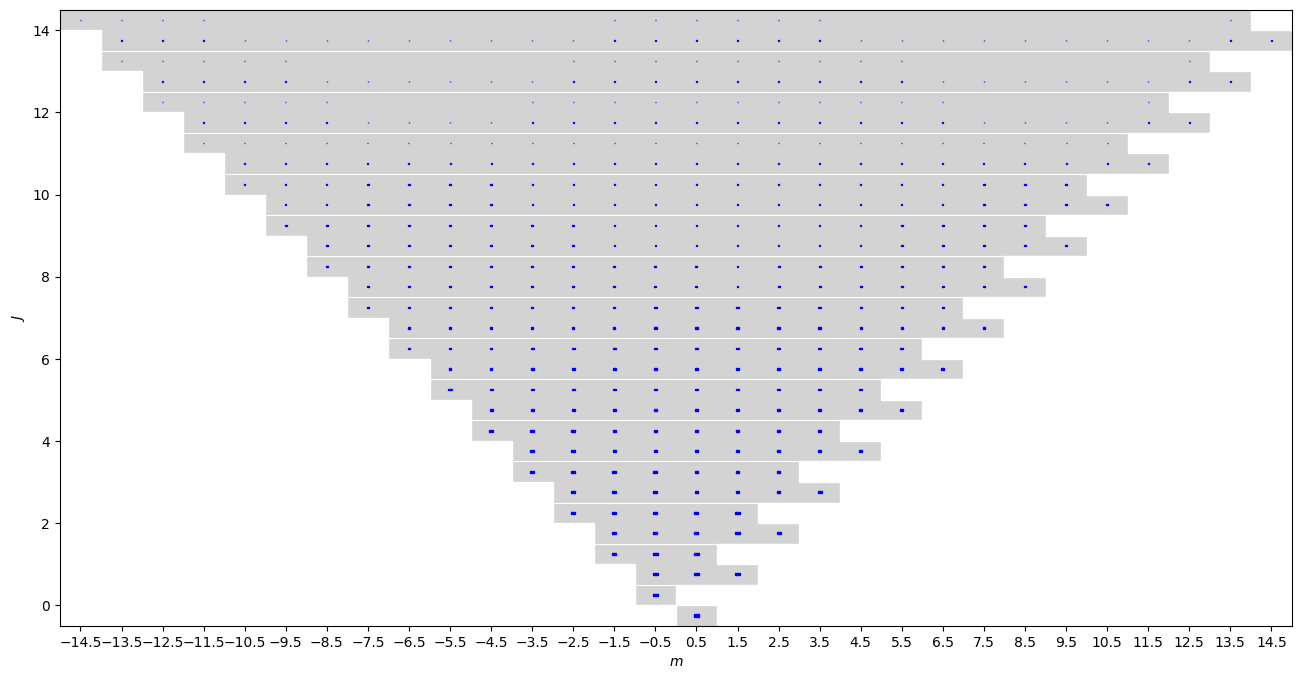

In [15]:
matrix = heatmap_state_pop(df1, j_max, normalize = False)

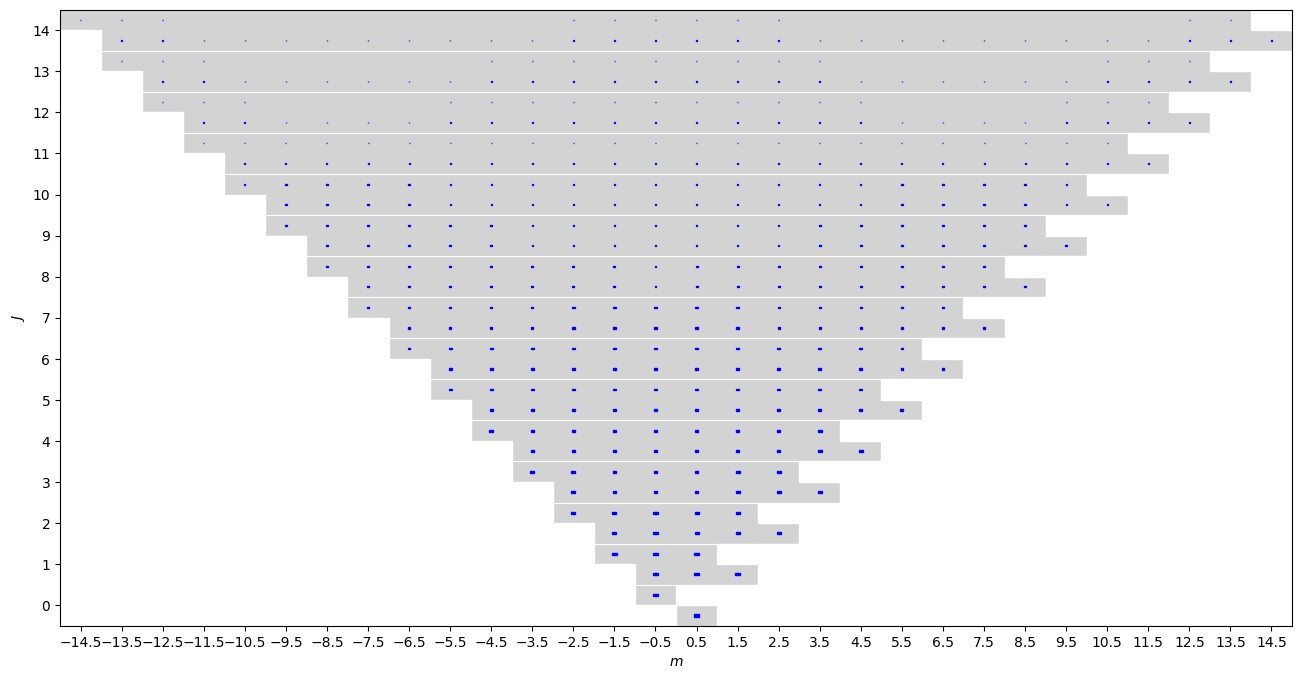

In [14]:
matrix = ut.heatmap_state_pop(df1, j_max, normalize = False)
# plt.show()

In [16]:

duration_us = 1000.0
rabi_rate_mhz = 2*np.pi*0.005
max_frequency_mhz = 0.05        # 50 kHz
scan_points = 1000
dephased = False
coherence_time_us = 100
is_minus = True


pump_frequency_mhz = -0.002
num_pumps = 200
pump_dephased = True
pump_rabi_rate_mhz = 2*np.pi*0.004
pump_duration_us = 1000.0




# Pumping
for _ in range(num_pumps):
    exc_matrix = qls.excitation_matrix(mo1, pump_frequency_mhz, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus).dot(mo1.state_df["state_dist"])
    mo1.state_df["state_dist"] += exc_matrix


    mask = mo1.state_df["state_dist"] < 0
    if np.abs(sum(exc_matrix)) >= 1e-10:
        raise ValueError("Error: sum of exc_matrix is not 0")

    if (mo1.state_df["state_dist"].shape) != (exc_matrix.shape):
        raise ValueError(f"Error: Shape mismatch. state_dist has shape {mo1.state_df['state_dist'].shape}, but exc_matrix has shape {exc_matrix.shape}")

    if np.sum(mask) > 0 : 
        raise ValueError("Error: state_dist contains negative values")
    
df2 = mo1.state_df.copy()

pump_frequency_mhz = -0.006
num_pumps = 200
pump_dephased = True
pump_rabi_rate_mhz = 2*np.pi*0.004
pump_duration_us = 1000.0




# Pumping
for _ in range(num_pumps):
    exc_matrix = qls.excitation_matrix(mo1, pump_frequency_mhz, pump_duration_us, pump_rabi_rate_mhz, pump_dephased, coherence_time_us, is_minus).dot(mo1.state_df["state_dist"])
    mo1.state_df["state_dist"] += exc_matrix


    mask = mo1.state_df["state_dist"] < 0
    if np.abs(sum(exc_matrix)) >= 1e-10:
        raise ValueError("Error: sum of exc_matrix is not 0")

    if (mo1.state_df["state_dist"].shape) != (exc_matrix.shape):
        raise ValueError(f"Error: Shape mismatch. state_dist has shape {mo1.state_df['state_dist'].shape}, but exc_matrix has shape {exc_matrix.shape}")

    if np.sum(mask) > 0 : 
        raise ValueError("Error: state_dist contains negative values")
    


df3 = mo1.state_df.copy()

# fig, ax = plt.subplots(figsize=(10, 6))

# frequencies, exc_probs1_after = qls.get_spectrum(mo1, mo1.state_df["state_dist"], duration_us, rabi_rate_mhz, max_frequency_mhz, scan_points, dephased, is_minus)

# ax.plot(frequencies, exc_probs1_after, label = f"Pumped")      # Plot after pumping



# ax.bar(signature_transitions, states1.j_distribution()[1:], color="red", width=0.0005, alpha=0.1, label = "Ideal")
# ax.axvline(x=-0.002, color='black', linestyle='--')
# ax.axvline(x=-0.006, color='black', linestyle='--', label=f'Pump freq {-0.006*(1e3)} kHz, {-0.002*(1e3)} kHz')
# ax.legend()
# ax.set_xlabel("Frequency (MHz)")
# ax.set_ylabel("Excitation probability")
# ax.set_title(f"B={b_field_gauss}G, spectrum after N_pump={num_pumps}, pump rate={pump_rabi_rate_mhz/(2*np.pi):.3f}MHz, pump freq.={pump_frequency_mhz}MHz")

# a_lim = -max_frequency_mhz
# b_lim = 0
# ax.set_xlim([a_lim, b_lim])
# ax.set_ylim([0, 0.2])

# for i in range(j_max):
#     if signature_transitions[i] >= a_lim and signature_transitions[i] <= b_lim:
#         ax.text(signature_transitions[i], states1.j_distribution()[i+1], f"j={i+1}", ha='center', va='bottom', color='red', alpha=0.8)

# # plt.show()


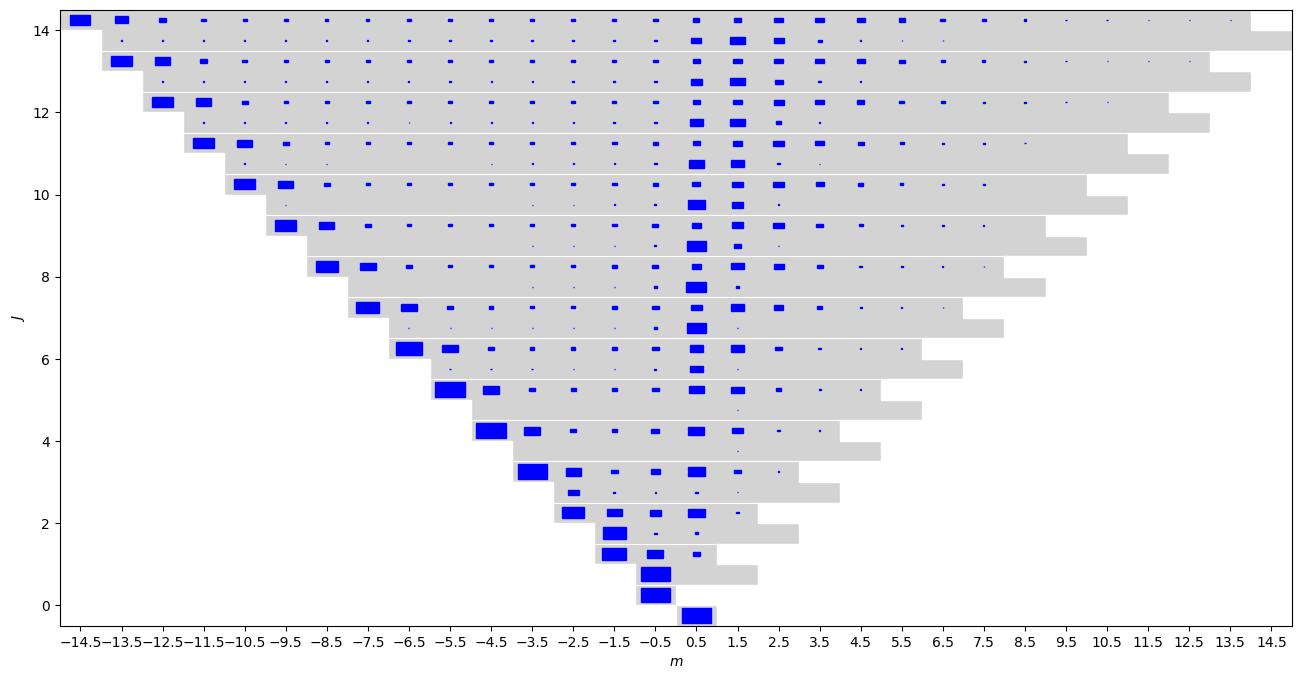

In [18]:
matrix = heatmap_state_pop(df2, j_max, normalize = True)

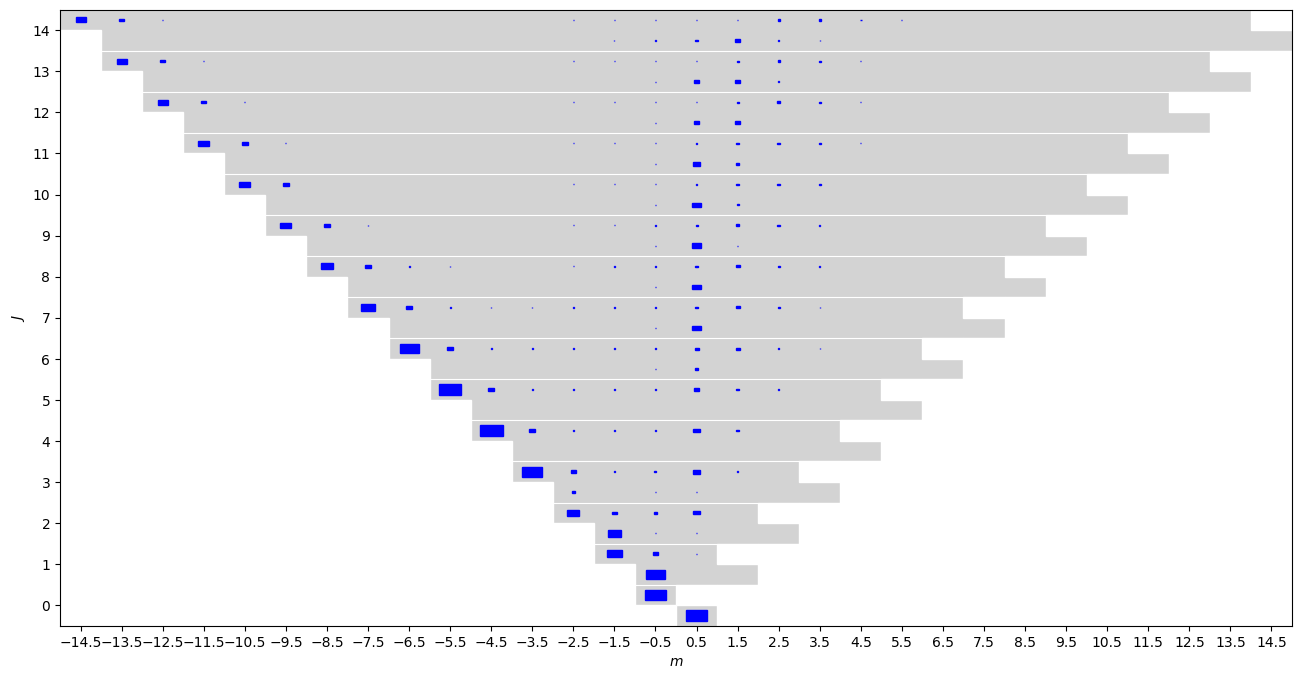

In [9]:
matrix = ut.heatmap_state_pop(df2, j_max, normalize = True)

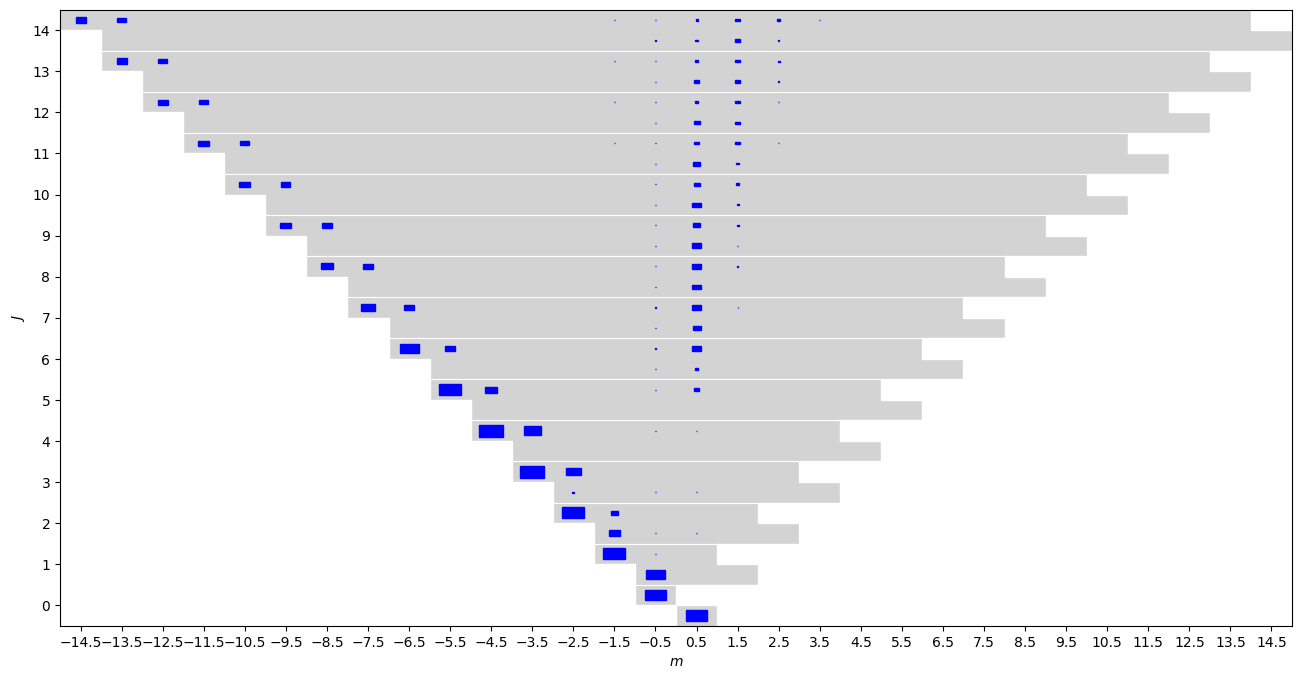

In [10]:
matrix = ut.heatmap_state_pop(df3, j_max, normalize = True)

In [8]:
dataframes = [df1, df2, df3]

In [11]:
dataframes[2]

,j,m,xi,spin_up,spin_down,zeeman_energy_khz,rotation_energy_ghz,state_dist
0,0,-0.5,False,0.000000,1.000000,7.663946,0.000000,1.137806e-02
1,0,0.5,True,1.000000,0.000000,-7.663946,0.000000,1.137806e-02
2,1,-1.5,False,0.000000,1.000000,-0.170634,285.003556,3.481125e-02
3,1,-0.5,False,0.326322,-0.945259,9.680271,285.003556,2.768615e-04
4,1,0.5,False,0.231433,-0.972851,16.887981,285.003556,1.843899e-14
...,...,...,...,...,...,...,...,...
445,14,10.5,True,0.945604,0.325320,-26.686777,29925.373359,9.925972e-13
446,14,11.5,True,0.959821,0.280612,-23.671542,29925.373359,4.373587e-13
447,14,12.5,True,0.973609,0.228221,-20.651341,29925.373359,2.194070e-13
448,14,13.5,True,0.986994,0.160755,-17.626299,29925.373359,1.217478e-13


In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_heatmap(dataframes, j_max, normalize=True, interval=1000):
    """
    Crea un'animazione in cui ogni frame è un plot generato dalla funzione heatmap_state_pop.
    
    Args:
        dataframes (list of pd.DataFrame): Lista di DataFrame da visualizzare in sequenza.
        j_max (int): Valore massimo di j.
        normalize (bool): Se normalizzare o meno state_dist.
        interval (int): Tempo tra un frame e l'altro in millisecondi.
    """

    fig, ax = plt.subplots(figsize=(10, 5))

    def update(frame):
        """Aggiorna la figura con il DataFrame corrente."""
        # ax.clear()  # Pulisce l'asse
        print(frame)
        print(f"Frame: {frame}")  # Debug
        heatmap_state_pop(dataframes[frame], j_max, normalize)  # Plotta il nuovo frame
        ax.clear()  # Pulisce l'asse

    num_frames = len(dataframes)
    print(f"Total frames: {num_frames}")  # Debug
    # Creazione dell'animazione
    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=interval, repeat=True)

    # Mostrare direttamente in un Jupyter Notebook
    
    return ani  # Alternativamente, puoi usare ani.save("output.gif", writer="pillow")

# Esempio di utilizzo
# animate_heatmap(lista_dataframes, j_max=5)


In [14]:
len(dataframes)

3

In [8]:
fig = heatmap_state_pop(mo1.state_df, j_max, normalize = True)

In [9]:
figures = [fig0, fig]

In [13]:
for i, fig in enumerate(figures):
    fig.savefig(f"heatmap_{i}.png")

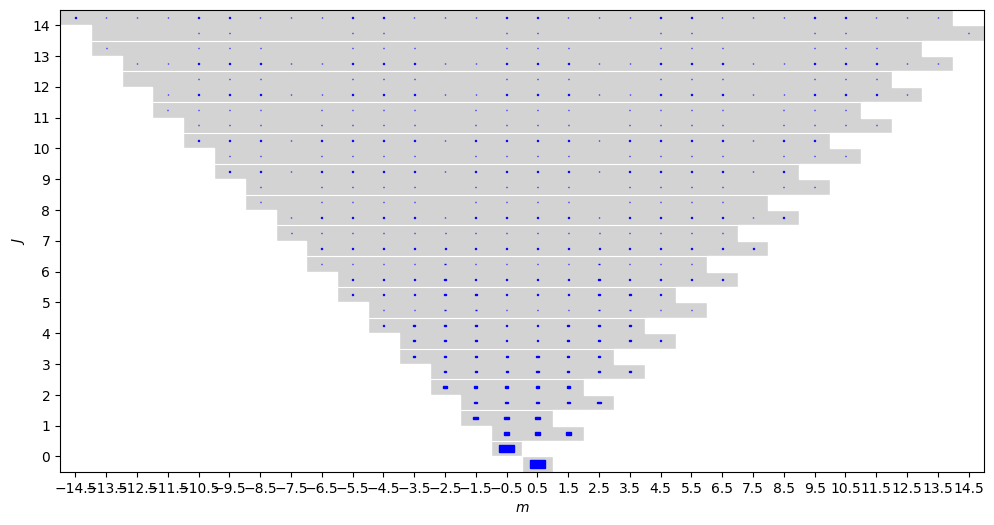

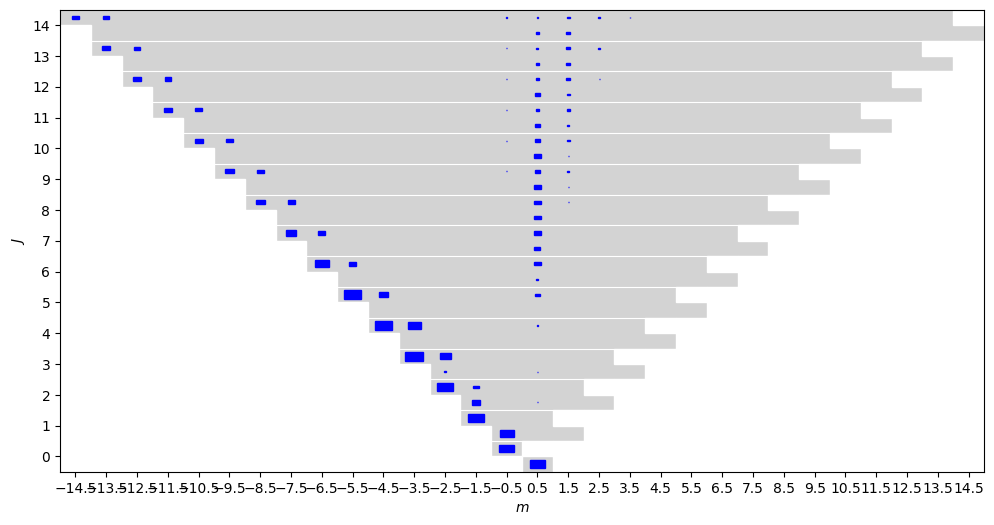

In [12]:
plt.show()